# This is code to downscale rough-resolution temperature to high-resolution one

## This is test for Himalaya and Tibet region (to see how AI handle stiff terrain is intersting case study)

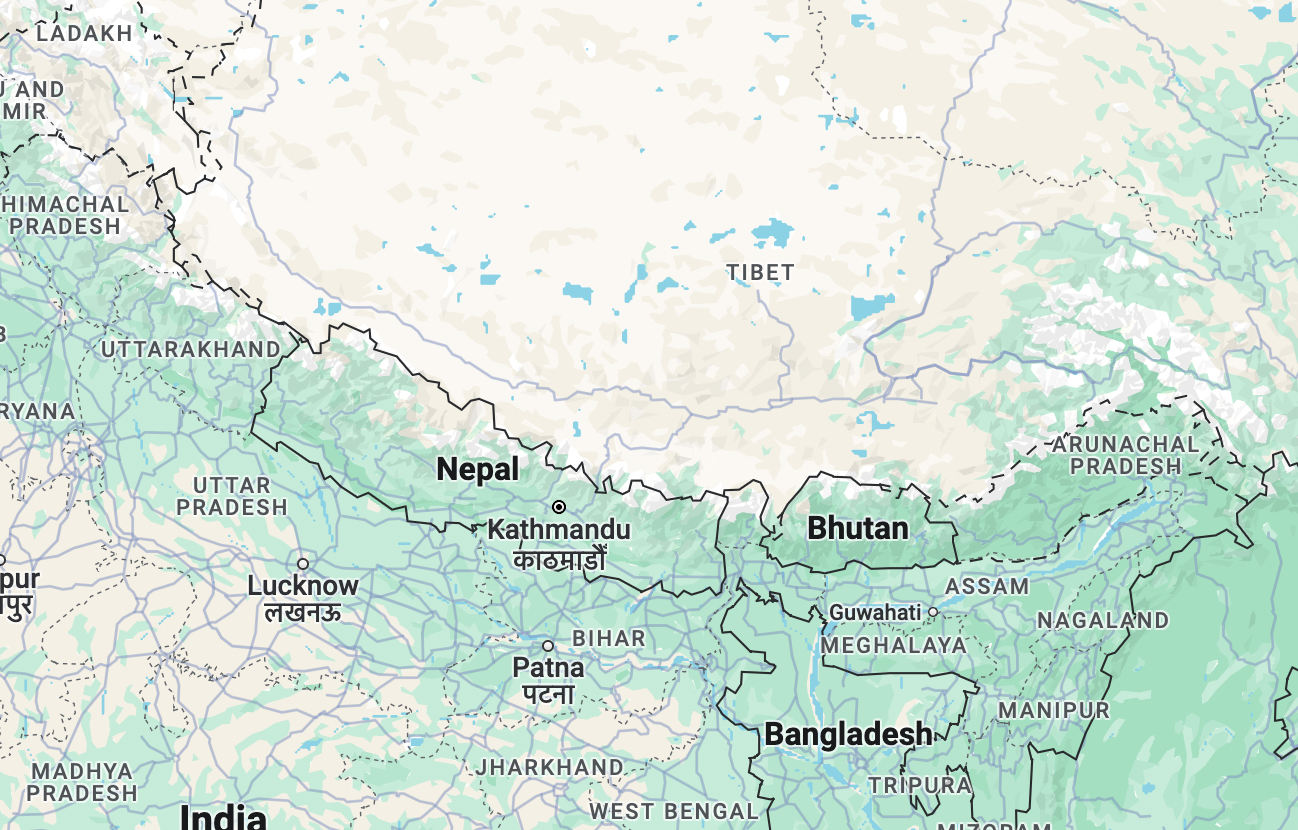




## first let import libaries

If there is necessity to install any libraries, do it.

For example

conda install scipy 


In [186]:
import numpy as np
import xarray as xr
#import ecubevis as ecv
#import climetlab as cml
import tensorflow as tf 
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
# all the layers used for U-net
from tensorflow.keras.layers import (Activation, BatchNormalization, Concatenate, Conv2D,
                                     Conv2DTranspose, Input, MaxPool2D)
from tensorflow.keras.models import Model
import tensorflow.keras.utils as ku
from tensorflow.keras.optimizers import Adam
import sys
#from unet_functions import lr_scheduler #, encoder_block, decoder_block, conv_block
print('===')

===


## Prepare input data for Unet


In [187]:
# =======
# preparing data
if 0:
    ds = xr.open_dataset('/Users/doan/Desktop/2023_2t_era5_land.nc')
    tb = ds.sel(longitude = slice(65,110), latitude = slice(50,15) )
    tb0 = tb.groupby('time.date').mean()
    tb0.date.values[:]  = pd.to_datetime(tb0.date.values).strftime('%Y%m%d')  #pd.to_datetime(tb0.date.values)
    tb0.to_netcdf('tb.nc')

if 1:
    #ifile = '/Users/doan/Desktop/2023_2t_era5_land.nc'
    #ds = xr.open_dataset(ifile)['t2m']
    ds = xr.open_dataset('tb.nc')['t2m']
    n = 7
    d1 = ds.interp(latitude=ds.latitude[::n], longitude = ds.longitude[::n])
    d2 = d1.rolling( {'latitude':7,'longitude':7}, center=True).mean()
    d4 = d2[:, ::n,::n]
    d5 = d4.interp(latitude=d1.latitude, longitude = d1.longitude, method= 'nearest')

    #d3 = xr.Dataset( {'hi': d1, 'lo':d2} ).sel(longitude = slice(73,100), latitude = slice(40,25) )
    d3 = xr.Dataset( {'hi': d1, 'lo':d5} ).sel(longitude = slice(75,97.25), latitude = slice(42.75,26) )
    print(d3)
    #d3.to_netcdf('tb_input.nc')
    

<xarray.Dataset>
Dimensions:    (date: 365, latitude: 24, longitude: 32)
Coordinates:
  * date       (date) object '20230101' '20230102' ... '20231230' '20231231'
  * latitude   (latitude) float32 42.3 41.6 40.9 40.2 ... 28.3 27.6 26.9 26.2
  * longitude  (longitude) float32 75.5 76.2 76.9 77.6 ... 95.1 95.8 96.5 97.2
Data variables:
    hi         (date, latitude, longitude) float32 261.5 270.0 ... 272.3 272.3
    lo         (date, latitude, longitude) float32 257.0 257.0 ... 272.3 272.3


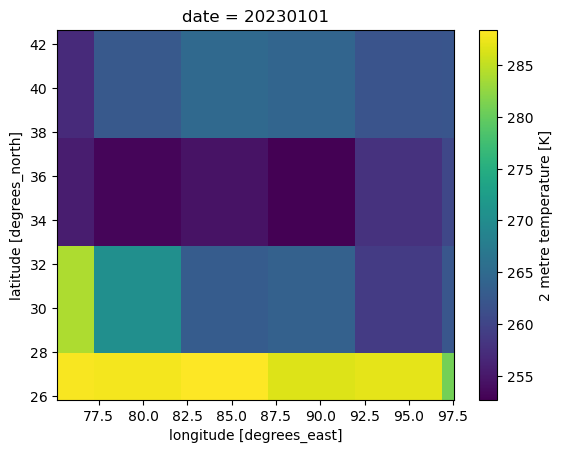

In [188]:
d3.lo[0].plot()

## Assume after above process we have data 



In [189]:
dinput = d3 #xr.open_dataset('tb_input.nc')
#n = 365
n = dinput['hi'].shape[0]
print('we have ', n, 'sample')

# separate data to three part: 1) training; 2) validation; 3) test
ii = np.arange(n)
n_train = int(round(.7*n))
print('extract: ', n_train, 'for training')

import random
itrain=[]
while len(itrain) !=  n_train :
   r=random.randint(0,n-1)
   if r not in itrain: itrain.append(r)

print( 'check len of training data: ', len(np.unique(itrain)), len(itrain))
print('get 70% of whole data to train: ', len(itrain))

i2 = np.setdiff1d(ii, itrain)
print('then we have remaining ', len(i2))

n_vt = len(i2)
n_val = int(round(.6*n_vt))

j1=[]
while len(j1) !=  n_val :
    r=random.randint(0, n_vt - 1)
    if r not in j1: j1.append(r)


ival = i2[j1]
itest = np.setdiff1d(i2, ival)

print(np.unique(np.union1d(itrain, np.union1d(ival, itest))).shape)
print(len(itrain) + len(ival) + len(itest))

we have  365 sample
extract:  255 for training
check len of training data:  255 255
get 70% of whole data to train:  255
then we have remaining  110
(365,)
365


In [190]:
dtrain0 = dinput.isel(date=itrain)
dval0 = dinput.isel(date=ival)
dtest0 = dinput.isel(date=itest)

# normalize data
drs = []
for d in [dtrain0, dval0, dtest0 ]:
    #xmin, xrange = d.min(), d.max() - d.min()
    #drs.append( (d - xmin) / xrange)
    x1, x2 = d.mean(), d.std()
    drs.append( (d - x1) / x2 )


dtrain, dval, dtest = drs

int_data = dtrain.lo.values
X_train = np.expand_dims(int_data,3)
y_train = dtrain.hi.values

X_val = np.expand_dims(dval.lo.values,3)
y_val = dval.hi.values

X_test = np.expand_dims(dtest.lo.values,3)
y_test = dtest.hi.values


## After long coding above, finally, what we want is three kinds of data

> Training data

> Validation data

> Testing data

In each kind of data: there should be two dataset

X (predictors) having four dimensions (n_sample, y_axis, x_axis, n_variables)

Y (preditant) having three or four dimensions (n_sample, y_axis, x_axis, n_variables (optional) )

In [191]:

print('Shape of X_train: ', X_train.shape)
print('Shape of y_train: ', y_train.shape)
print('Shape of X_validation: ', X_val.shape)
print('Shape of y_validation: ', y_val.shape)
print('Shape of X_test: ', X_test.shape)
print('Shape of y_test: ', y_test.shape)



Shape of X_train:  (255, 24, 32, 1)
Shape of y_train:  (255, 24, 32)
Shape of X_validation:  (66, 24, 32, 1)
Shape of y_validation:  (66, 24, 32)
Shape of X_test:  (44, 24, 32, 1)
Shape of y_test:  (44, 24, 32)


## Define encoder and decorder functions


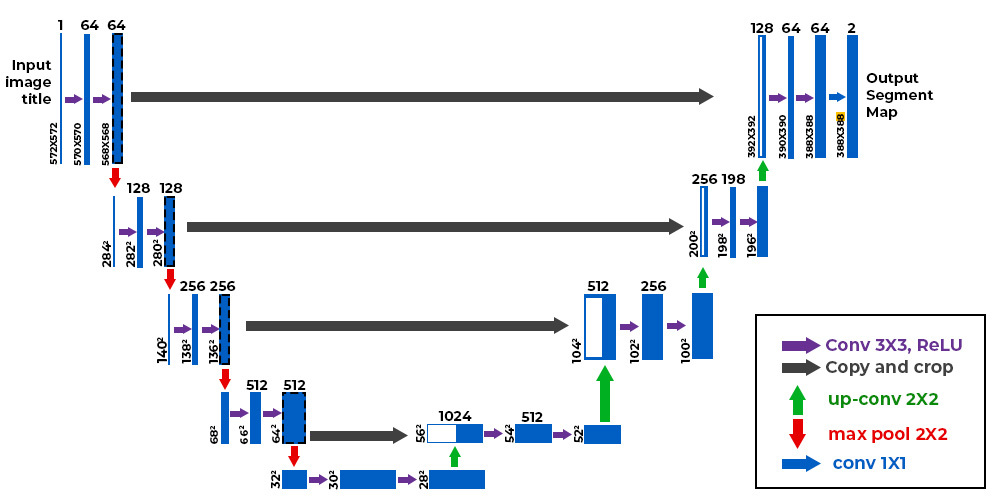


https://www.geeksforgeeks.org/u-net-architecture-explained/

With decoder UNet become different with normal CNN



In [192]:

def conv_block(inputs, num_filters: int, kernel: tuple = (3,3), padding: str = "same",
               activation: str = "relu", kernel_init: str = "he_normal", l_batch_normalization: bool = True):
    """
    A convolutional layer with optional batch normalization
    :param inputs: the input data with dimensions nx, ny and nc
    :param num_filters: number of filters (output channel dimension)
    :param kernel: tuple indictating kernel size
    :param padding: technique for padding (e.g. "same" or "valid")
    :param activation: activation fuction for neurons (e.g. "relu")
    :param kernel_init: initialization technique (e.g. "he_normal" or "glorot_uniform")
    """
    x = Conv2D(num_filters, kernel, padding=padding, kernel_initializer=kernel_init)(inputs)
    if l_batch_normalization: x = BatchNormalization()(x)
    x = Activation(activation)(x)
    return x


def conv_block_n(inputs, num_filters, n=2, kernel=(3,3), padding="same", activation="relu", 
                     kernel_init="he_normal", l_batch_normalization=True):
    """
    Sequential application of two convolutional layers (using conv_block).
    """
    
    x = conv_block(inputs, num_filters, kernel, padding, activation,kernel_init, l_batch_normalization)
    for i in np.arange(n-1):
        x = conv_block(x, num_filters, kernel, padding, activation,kernel_init, l_batch_normalization)
    
    return x

def encoder_block(inputs, num_filters, kernel_maxpool: tuple=(2,2), l_large: bool=True):
    """
    One complete encoder-block used in U-net
    """
    if l_large: x = conv_block_n(inputs, num_filters, n=2)
    else: x = conv_block(inputs, num_filters) 
    p = MaxPool2D(kernel_maxpool)(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters, kernel: tuple=(3,3), strides_up: int=2, padding: str= "same", 
                  activation="relu", kernel_init="he_normal", l_batch_normalization: bool=True):
    """
    One complete decoder block used in U-net (reverting the encoder)
    """
    x = Conv2DTranspose(num_filters, (strides_up, strides_up), strides=strides_up, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block_n(x, num_filters, 2, kernel, padding, activation, kernel_init, l_batch_normalization)
    
    return x




In [193]:
# define a earning-rate scheduler
def lr_scheduler(epoch, lr):
  if epoch < 5:
    return lr
  elif epoch >= 5 and epoch < 30:
    return lr * tf.math.exp(-0.1)
  elif epoch >= 30:
    return lr

In [194]:
# running unet using unet_functions
rununet = 1
if rununet:
    #shape_in = (96, 128, 3)
    # parameters 
    batch_size = 32
    epochs = 150
    
    
    shape_in = X_train.shape[1:]
        
    callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
    
    # build model    
    inputs = Input(shape_in)
    
    """ encoder """
    channels_start=56
    #channels_start=16
    
    s1, e1 = encoder_block(inputs, channels_start, l_large=True)
    s2, e2 = encoder_block(e1, channels_start*2, l_large=False)
    s3, e3 = encoder_block(e2, channels_start*4, l_large=False)
    
    """ bridge encoder <-> decoder """
    b1 = conv_block(e3, channels_start*8)
    
    """ decoder """
    d1 = decoder_block(b1, s3, channels_start*4)
    d2 = decoder_block(d1, s2, channels_start*2)
    d3 = decoder_block(d2, s1, channels_start)
    
    output_temp = Conv2D(1, (1,1), kernel_initializer="he_normal", name="output_temp")(d3)
    
    unet_model= Model(inputs, output_temp, name="t2m_downscaling_unet")
    
    #ku.plot_model(unet_model, show_shapes=True)
    
    unet_model.compile(optimizer=Adam(learning_rate=5*10**(-4)), loss="mae")
    
    if 1:
        history = unet_model.fit(x=X_train, 
                                 y=y_train, 
                                 batch_size=batch_size,
                                 epochs=epochs, 
                                 callbacks=[callback],
                                 validation_data=(X_val, y_val ),
                                 verbose = 0 # dont show ====== if want to show =1
                                 )
        # save model to ecmwf
        unet_model.save('tb_small')
        print('Finished run')

INFO:tensorflow:Assets written to: tb_small/assets


INFO:tensorflow:Assets written to: tb_small/assets


Finished run


## Predict and verification

In [195]:


if 1: 
    # load model and run
    xmodel = tf.keras.models.load_model('tb_small') 
    
    #print(xmodel.summary())
    
    y_pred_val = xmodel.predict(X_val, verbose=1)
    y_pred_test = xmodel.predict(X_test, verbose=1) 

    # return values to Kelvin 
    x1, x2 = dtest0.mean()['hi'], dtest0.std()['hi']
    y_pred_test_r = y_pred_test*x2.values + x1.values

    x1, x2 = dval0.mean()['hi'], dval0.std()['hi']
    y_pred_val_r = y_pred_val*x2.values + x1.values
    

    do = xr.Dataset( )
    do['pred'] = ( ('dat', 'latitude', 'longitude'), y_pred_test_r.squeeze())  
    do.coords['latitude'] = dtest0.latitude
    do.coords['longitude'] = dtest0.longitude
    do['real'] = dtest0['hi']

    dv = xr.Dataset( )
    dv['pred'] = ( ('dat', 'latitude', 'longitude'), y_pred_val_r.squeeze())  
    dv.coords['latitude'] = dval0.latitude
    dv.coords['longitude'] = dval0.longitude
    dv['real'] = dval0['hi']

    do.to_netcdf('prediction.nc')
    dv.to_netcdf('validation.nc')
    do.close()
    dv.close()
    
    #do.pred[0].plot()
    #plt.show()
    #dtest0['hi'][0].plot()
    #plt.show()
    #bias = do.pred - dtest0.hi.values
    #bias[0].plot()
    #print(bias.mean())   

2/2 [==============================] - 0s 2ms/step


<xarray.Dataset>
Dimensions:    (dat: 44, latitude: 24, longitude: 32, date: 44)
Coordinates:
  * latitude   (latitude) float32 42.3 41.6 40.9 40.2 ... 28.3 27.6 26.9 26.2
  * longitude  (longitude) float32 75.5 76.2 76.9 77.6 ... 95.1 95.8 96.5 97.2
  * date       (date) object '20230119' '20230120' ... '20231214' '20231227'
Dimensions without coordinates: dat
Data variables:
    pred       (dat, latitude, longitude) float32 260.9 268.0 ... 272.3 272.3
    real       (date, latitude, longitude) float32 261.3 269.3 ... 272.3 272.3
<xarray.Dataset>
Dimensions:    (dat: 66, latitude: 24, longitude: 32, date: 66)
Coordinates:
  * latitude   (latitude) float32 42.3 41.6 40.9 40.2 ... 28.3 27.6 26.9 26.2
  * longitude  (longitude) float32 75.5 76.2 76.9 77.6 ... 95.1 95.8 96.5 97.2
  * date       (date) object '20230422' '20231128' ... '20230404' '20230117'
Dimensions without coordinates: dat
Data variables:
    pred       (dat, latitude, longitude) float32 276.0 280.2 ... 288.5 286.3
    r

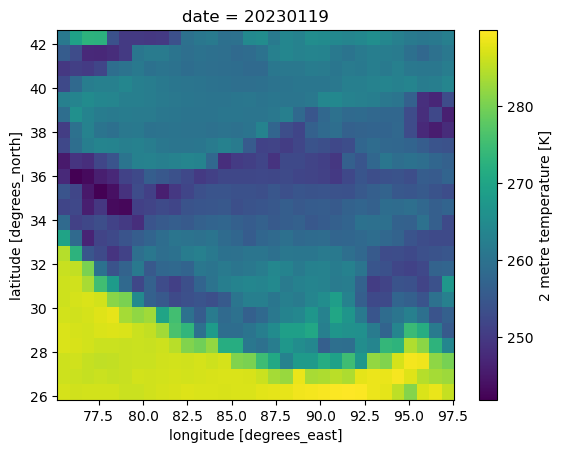

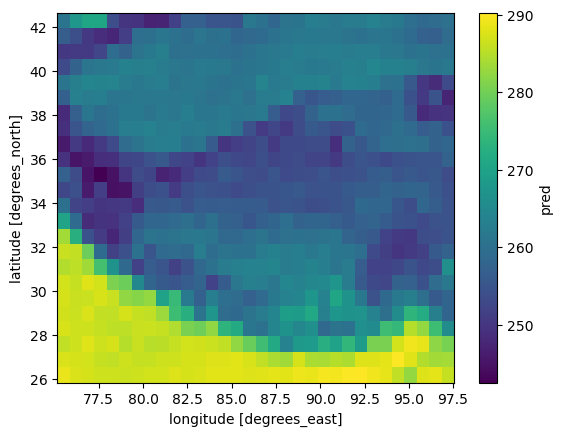

In [116]:
print(do)
print(dv)

do['real'][0].plot()
plt.show()
do['pred'][0].plot()


(24, 32) (24, 32)
<xarray.DataArray 'lo' ()>
array(14.9510498)
Coordinates:
    date     <U8 '20230102'
<xarray.DataArray ()>
array(3.42922974)
Coordinates:
    date     <U8 '20230102'
<xarray.DataArray 'pred' ()>
array(17.93530273)
<xarray.DataArray 'real' ()>
array(17.90582275)
Coordinates:
    date     <U8 '20230102'


SystemExit: 

/home/doanquangvan/.conda/envs/tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


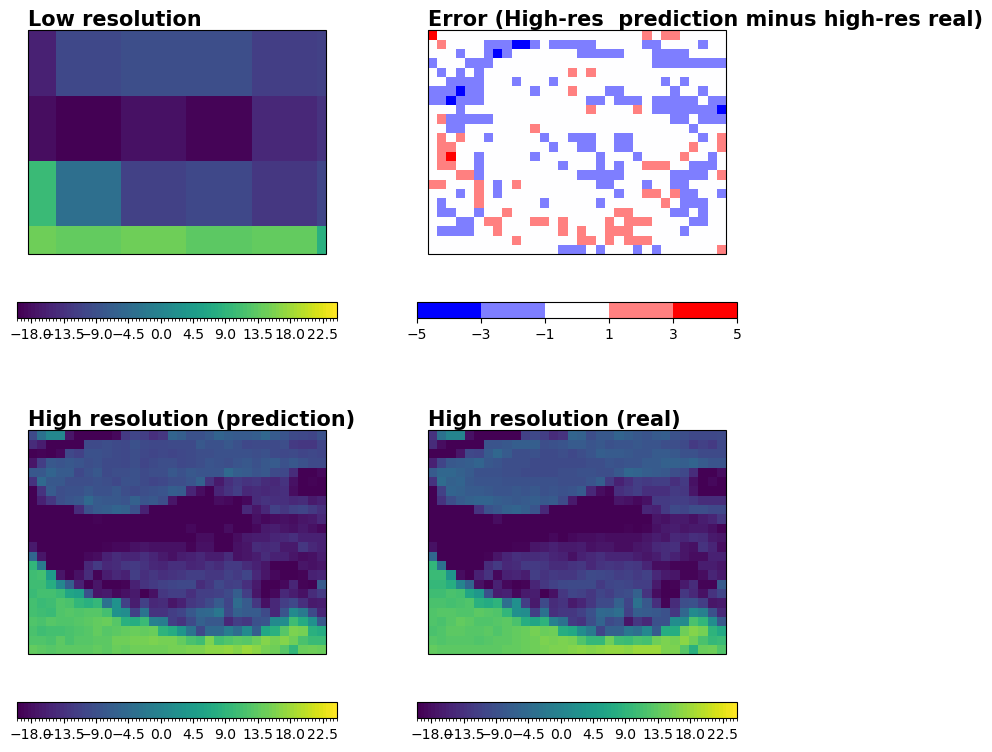

In [196]:
#dtest0['lo'][0].plot()
import cartopy
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt






lat, lon = do.latitude.values, do.longitude.values
ntime = 0
zz = [ dtest0['lo'][ntime] - 273.15, do['pred'][ntime] - do['real'][ntime], 
      do['pred'][ntime]-273.15, do['real'][ntime]-273.15 ] 


lat2d, lon2d = np.meshgrid(lon, lat)
print( z.shape, lat2d.shape)

fig = plt.figure(figsize=(8,8))

level = np.arange(-20., 25., .5)
levels = [ level,  np.linspace(-5, 5, 6), level, level ] 



for i in range(4):
    
    ax = plt.axes( [ [.1, .6, .1, .6 ][i] , 
                    [.6,.6,.1,.1][i], 
                    .4, .4 ], projection = ccrs.PlateCarree())
    
    z = zz[i]
    print(z.max())

    cm1 = 'viridis'
    cmap = [ plt.colormaps[ cm ] for cm in [cm1, 'bwr', cm1, cm1] ][i]
    
    norm = mpl.colors.BoundaryNorm(levels[i], cmap.N)  
    t = ax.pcolormesh(lat2d, lon2d, z, cmap=cmap, norm=norm)

    #cax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
    #cbar = plt.colorbar(orientation="vertical", ticks=lvl[1::2])
    #cbar.ax.tick_params(labelsize=12)


    fig.colorbar(t, orientation='horizontal')

    ax.text( .0, 1.02, 
            ['Low resolution', 'Error (High-res  prediction minus high-res real)', 'High resolution (prediction)', 'High resolution (real)' ][i], 
            fontsize = 15, 
            fontweight = 'bold',
            transform = ax.transAxes)

sys.exit()


## Look at procesess 

In [ ]:
xmodel.summary()

In [ ]:
#
l1 = xmodel.layers[1]
print(l1 )
l1.filters
#x = l1(img_tensor)
#x.get_shape()

w1 = xmodel.layers[1].get_weights()
print(len(w1))

print(w1[0].shape)
print(w1[1].shape)

print(w1[0][:,:,0,0])
for i in range(32)[:1]:
    plt.imshow(w1[0][:,:,0,i])
    plt.show()
print(w1[0].size+w1[1].size)



(44, 24, 32, 1)

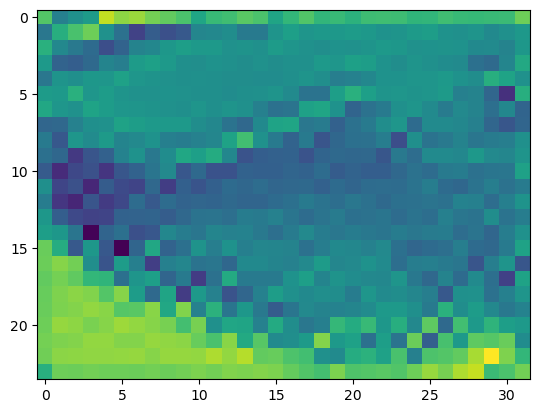

In [197]:
#y1 = xmodel.layers[1](X_test, verbose=1) 
#print(y1.shape)
#plt.imshow(y1[0])
a1 = xmodel.layers[1]
print(a1)

yy = np.expand_dims(y_test,3)


plt.imshow( a1(yy[:,:,:,:])[0,:,:,-1] )
           
y_test.shape
X_test.shape